# Abalone Data Clustering Using KDBSCAN

##### Original Paper:
Gholizadeh, N., Saadatfar, H. & Hanafi, N. *K-DBSCAN: An improved DBSCAN algorithm for big data*. J Supercomput 77, 6214–6235 (2021). https://doi.org/10.1007/s11227-020-03524-3

Steps:
1. Load the abalone dataset from the uciml repo python library
2. Extract the features
3. Perform KMeans clustering using KMeans++ for the initialised centroids
4. Merge clusters based on a defined distance formula and *ε* such that two clusters are merged if the distance between them, *d* < *ε*
5. On each of the clusters obtained in step 4, perform DBSCAN

References:
1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
3. http://archive.ics.uci.edu/dataset/1/abalone

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN 
from scipy.spatial.distance import cdist

In [2]:
# Fetch the abalone dataset 
abalone = fetch_ucirepo(id=1) 
  
# data is stored as a pandas dataframe
X = abalone.data.features 
y = abalone.data.targets

In [3]:
# Features
X.head(10)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320


In [4]:
# Checking the stats of the features

X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
dtypes: float64(7), object(1)
memory usage: 261.2+ KB


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


In [5]:
# Target column to be discarded
y.head()

,Rings
0,15
1,7
2,9
3,10
4,7


In [6]:
# Scaling/standardizing the features

scaled_X = X
scaler = StandardScaler()
scaled_X[
    ['Length', 'Diameter', 'Height',
     'Whole_weight', 'Shucked_weight',
     'Viscera_weight', 'Shell_weight']] = scaler.fit_transform(scaled_X[
    ['Length', 'Diameter', 'Height',
     'Whole_weight', 'Shucked_weight',
     'Viscera_weight', 'Shell_weight']])

scaled_X

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4532\2699034783.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_X[


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,F,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,M,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,M,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,F,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


In [7]:
# Creating a dataframe to store scaled features

abalone = scaled_X
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757


In [8]:
# Label encoding the Sex column

abalone['Sex'] = LabelEncoder().fit_transform(abalone['Sex'])
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757


In [9]:
# # Alternative - dropping the Sex column
# abalone = abalone.drop(['Sex'], axis=1)
# abalone

#### KMeans++ clustering on abalone dataset

In [10]:
# number of clusters as proposed in the paper = sqrt(n_samples)
import math
num_clusters = math.floor(np.sqrt([len(abalone)])[0])
num_clusters

64

In [11]:
# Checking our dataset
abalone

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,2,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,0,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,2,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,1,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,0,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,2,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,2,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,0,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


In [12]:
# Running KMeans++ with num_clusters
start = time.time()
km_abalone = KMeans(init='k-means++', n_clusters=num_clusters, random_state=69, n_init='auto', max_iter=4).fit(abalone)
# km_abalone.labels_

In [13]:
# Retrieving KMeans cluster centroids
# km_abalone.cluster_centers_

In [14]:
# Creating a column to store predicted clusters

cluster = []
for val in km_abalone.labels_:
    cluster_label = "KC"+str(val)
    cluster.append(cluster_label)
# cluster

In [15]:
# Appending the predicted clusters to our dataset
clustered_abalone = abalone.copy()
clustered_abalone['cluster'] = cluster
# clustered_abalone.head(10)

In [16]:
# Storing the samples in each cluster in a dictionary with the cluster name as key and a dataframe with samples belonging
# to those clusters as the value

cluster_samples = {}
labels = set(cluster)
for label in labels:
    cluster_samples[label] = clustered_abalone.loc[clustered_abalone['cluster'] == label]

In [17]:
# We create a similar dictionary to store features of each sample in each cluster

cluster_features = {}
for label in labels:
    cluster_features[label] = cluster_samples[label].drop(['cluster'], axis=1)
# abalone = abalone.drop(['cluster'], axis=1)
# cluster_features["KC63"]

We will use fixed value for epsilon to be used for the DBSCAN algorithm.

In [18]:
db_epsilon = 2.0

In [19]:
# Running DBSCAN on each cluster and storing the results
dbscan_clusters = {}

# Running DBSCAN on each cluster
for i in range(0, num_clusters):
    label = "KC" + str(i)
    
    current = cluster_features[label] # current dataframe    
    dbscan = DBSCAN(eps=db_epsilon, min_samples=4).fit(cluster_features[label])
#     valid_clus = set(dbscan.labels_).difference([-1]) # removing noise points
    numclu = len(set(dbscan.labels_)) # total number of non-noise DBSCAN clusters identified in the current KMeans cluster
    
    current['db_clus'] = dbscan.labels_ # marking each sample with it's dbscan cluster number
    db_samples = {}
    if numclu > 0:
        for p in set(dbscan.labels_):
            db_samples[str(p)] = current.loc[current['db_clus'] == p].drop(['db_clus'], axis=1)

    dbscan_clusters[label] = db_samples

In [20]:
# Checking if everything has worked properly
# dbscan_clusters["KC0"]["0"]

### Merging clusters

In this step, we examine each of the groups obtained from KMeans clustering to see if any of the clusters can be merged. The authors proposed the following distance formula for calculating pairwise distances between the groups:
<br><br>
<div style="text-align: center;">
    <i>
        <strong>dis_K<sub>ij</sub> = dis_KC<sub>ij</sub> - (dis_r<sub>i</sub> + dis_r<sub>j</sub></strong>)
    </i>, where
    <br><br>
    <i><strong>dis_K<sub>ij</sub></strong></i> = distance between clusters <i>i</i> and <i>j</i>,
    <br>
    <i><strong>dis_KC<sub>ij</sub></strong></i> = distance between the cluster centers of clusters <i>i</i> and <i>j</i>,
    <br>
    <i><strong>dis_r<sub>i</sub></strong></i> = distance of the furthest point in cluster <i>i</i> to the corresponding center, and
    <br>
    <i><strong>dis_r<sub>j</sub></strong></i> = distance of the furthest point in cluster <i>j</i> to the corresponding center
</div>

In [21]:
# We will be using the Euclidean distance when calculating distance between KMeans groups
from scipy.spatial import distance

In [22]:
# Defining a function to calculate distance between two groups/clusters
def minC_distance(a, b):
    return np.min(cdist(a, b))

##### Saving centers and farthest point of each cluster in a dictionary

In [23]:
km_centers = {}
farthest_point = {}

for i in range(0, num_clusters):
    # finding the center of cluster i
    label = "KC" + str(i)
    center = km_abalone.cluster_centers_[i]
    km_centers[label] = center
    
    # iterating through each sample in cluster i to find the farthest point
    samples = cluster_features[label].drop(['db_clus'], axis=1).to_numpy() 
    max_dist = 0
    for sample in samples:        
        dist = distance.euclidean(np.array(sample), center)
        if dist >= max_dist:
            farthest_point[label] = {"point": np.array(sample),"distance": dist}
            max_dist = dist

##### Computing pairwise distances of each cluster using the distance formula defined earlier

In [24]:
# Initialise the matrix with infinity values
pairwise_distance = np.full((num_clusters, num_clusters), np.inf)

for i in range(0, num_clusters):
    ci = "KC" + str(i) # label of cluster i
    
    for j in range(i + 1, num_clusters):
        cj = "KC" + str(j) # label of cluster j
        if i == j:
            pairwise_distance[i][j] = 0
        else:
            pairwise_distance[i][j] = distance.euclidean(km_centers[ci], km_centers[cj]) 
            - (farthest_point[ci]["distance"] + farthest_point[cj]["distance"])


# utility function that returns the pairwise distance of two groups
def pair_dist_group(i, j):
    return pairwise_distance[i][j]

In [25]:
# Scratchpad
# s = '2'
# type(int(s))

In [26]:
# cluster_samples - contains list of KMeans groups
# dbscan_clusters - contains dbscan clusters for each KMeans group

counter = 1
flag = {}
flag_ref = {}
k = num_clusters # number of kmeans groups
epsilon = 3.0 # distance above which clusters will be pruned
MinPts = 4

# temp = []

for a in range(k-1):
    label_k1 = "KC" + str(a)
    num_1 = len(dbscan_clusters[label_k1]) # # of dbscan clusters in group a
    for b in range(k):
        label_k2 = "KC" + str(b)
        num_2 = len(dbscan_clusters[label_k2]) # of dbscan clusters in group b
        dis_k = pair_dist_group(a, b)
        if dis_k <= epsilon:
            group1 = dbscan_clusters[label_k1]
            group2 = dbscan_clusters[label_k2]
            if num_1 > 0 and num_2 > 0:
                for c in group1.keys():
                    cluster1 = group1[c]
                    for d in group2.keys():                        
                        cluster2 = group2[d]
                        dis_db = minC_distance(cluster1, cluster2)
                        
                        # converting all keys to integers
                        int_a = int(a)
                        int_b = int(b)
                        int_c = int(c)
                        int_d = int(d)
                        
                        if dis_db <= epsilon:
                            if(int_a, int_c) not in flag and (int_b, int_d) not in flag:
                                flag[(int_a, int_c)] = counter
                                flag[(int_b, int_d)] = counter
                                flag_ref[('a_'+str(int_a), 'c_'+str(int_c))] = counter
                                flag_ref[('b_'+str(int_b), 'd_'+str(int_d))] = counter
                                counter += 1
                            else:
                                flag[(int_a, int_c)] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag[(int_b, int_d)] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag_ref[('a_'+str(int_a), 'c_'+str(int_c))] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))
                                flag_ref[('b_'+str(int_b), 'd_'+str(int_d))] = max(flag.get((int_a, int_c), 0), flag.get((int_b, int_d), 0))

In [27]:
# List of clusters that need to be merged
# for itm in flag_ref.keys():
#     print(itm)

In [28]:
# Create an empty dataset to store the merged clusters

final_data = pd.DataFrame(columns=abalone.columns)
# final_data.head()

In [29]:
# Appending all the clusters to be merged to final_data
for tup in flag_ref.keys():
    group = tup[0].split('_')[1]
    cluster = tup[1].split('_')[1]
    samples = dbscan_clusters['KC'+str(group)][str(cluster)]
    final_data = final_data.append(samples)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4532\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4532\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4532\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4532\2430363145.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = final_data.append(samples)
C:\Users\ASUS\AppData\Local\Temp\ipykern

In [30]:
# Checking if everything worked
# final_data

In [31]:
# Remove duplicates created while merging
final_data = final_data.drop_duplicates()
# final_data

##### Run DBSCAN algorithm in the clusters with same flag

In [32]:
labels = DBSCAN(eps=db_epsilon, min_samples=4).fit(final_data).labels_

# Calculating time taken for the proposed algorithm
t_A = round((time.time() - start), 2)

print("The proposed algorithm took ", t_A, "seconds.")
print("FINAL LABELS ->", labels)
labels

The proposed algorithm took  2.22 seconds.
FINAL LABELS -> [ 0  0  0 ...  0 -1  0]


array([ 0,  0,  0, ...,  0, -1,  0], dtype=int64)

In [33]:
# storing cluster assigned to each point in a new column
final_data['cluster'] = labels
final_data

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,cluster
16,1,-1.407346,-1.288762,-1.303532,-1.097713,-1.191186,-1.287337,-0.889679,0
21,1,-1.199149,-1.339151,-0.944870,-1.230277,-1.258773,-1.200659,-1.105218,0
45,1,-1.115871,-1.137595,-1.064424,-1.276165,-1.224979,-1.237155,-1.177064,0
100,1,-1.365707,-1.439929,-1.064424,-1.218040,-1.146128,-1.228031,-1.177064,0
121,1,-1.157510,-1.137595,-1.303532,-1.173173,-1.155140,-1.123105,-1.105218,0
...,...,...,...,...,...,...,...,...,...
1428,0,2.423480,2.440025,2.641755,2.908769,2.393175,2.184342,4.013831,0
1174,0,0.924461,0.877965,-2.977291,0.668443,0.685478,1.162455,0.356854,-1
1762,2,2.048725,2.137691,1.326659,3.440044,3.406979,4.205307,2.896621,0
1763,2,2.090364,2.238469,2.641755,3.978457,4.456829,5.286500,2.436805,-1


In [34]:
# Number of clusters obtained (before dealing with noise):
k = len(final_data['cluster'].unique())

# These clusters include noise labeled as -1, we will change that to cluster number (k-1)
final_data = final_data.replace({'cluster': {-1: k-1}})

# Number of clusters obtained (after dealing with noise):
k = len(final_data['cluster'].unique())

final_data['cluster'].unique()

array([0, 1], dtype=int64)

## Results

### Davies-Boulding (DB) metric

This is a metric based on the ratio of within-cluster and between-cluster distances. It is defined as follows:
<div style="text-align: center;">D<sub>ij</sub> = $\frac{1}{k}$$\sum_{i=1}^{k}$ max$_{(j≠i)}${D<sub>i.j</sub>}</div>

In this equation, ${k}$ represents the number of clusters and D<sub>i.j</sub> indicates within-to between cluster distance ratio, which is defined as follows:

<div style="text-align: center;">D<sub>i.j</sub> = $\frac{(\bar{d_{i}} - \bar{d_{j}})}{d_{i.j}}$</div>

where:
<div style="text-align: center;">
$d_{i.j}$ = Euclidean distance between the centers of clusters ${i}$ and ${j}$
</div>
<div style="text-align: center;">
$d_{i}$ = mean distance between all the pieces of data in cluster ${i}$ and the center of cluster ${i}$
</div>
<div style="text-align: center;">
$d_{j}$ = mean distance between all the pieces of data in cluster ${i}$ and the center of cluster ${j}$
</div>

A smaller value for the DB metric shows higher clustering quality.

In [35]:
# Function to calculate the center for a cluster

def calculate_center(data):
    mean = np.mean(data, axis=0)
    return mean

In [36]:
# Function to calculate mean distance each point in a cluster to its center

def calc_di(cluster, center):
    dist = 0
    for point in cluster:
        dist += distance.euclidean(point, center) # Using the previously imported euclidean distance library function
    return (dist/len(cluster)) 

In [37]:
# Storing cluster centroids and mean distances of each point of a cluster to the corresponding centroid

cluster_centroids = {}
mean_distances = {}
for i in set(final_data['cluster'].unique()):
    cluster_data = list(final_data[final_data.cluster == i].drop(['cluster'], axis=1).itertuples(index=False, name=None))
    
    cluster_centroids[str(i)] = calculate_center(cluster_data)
    mean_distances[str(i)] = calc_di(cluster_data, cluster_centroids[str(i)])    
        
# mean_distances

###### Calculating Davies-Bouldin (DB) metric

In [38]:
max_distance_ratio = 0
# k = sum(1 for i in final_data['cluster'].unique() if i != -1)
k = len(final_data['cluster'].unique())
for i in range(k-1):
    D_ij = 0 #  indicates within-to between cluster distance ratio for each i != j    
    di = mean_distances[str(i)] # dj = mean distance of all points in cluster i to the centroid of cluster i
    
    for j in range(i+1, k):
        # d_ij (not D_ij) indicates the distance between the centroids of clusters i and j
        d_ij = distance.euclidean(cluster_centroids[str(i)], cluster_centroids[str(j)])
        
        # dj = mean distance of all points in cluster j to the centroid of cluster j
        dj = mean_distances[str(j)]
        
        # Calculating within-to-between cluster distance ratio
        D_ij = (di + dj) / d_ij
        
        if max_distance_ratio < D_ij:
            max_distance_ratio = D_ij

# Dividing by k to get the DB metric
DB = round((max_distance_ratio / k), 4)

print("The Davies-Bouldin metric for clustering using the proposed algorithm is ", DB)        

The Davies-Bouldin metric for clustering using the proposed algorithm is  1.295


### Silhouette Score

Ref: [sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

The silhouette score uses the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample, and is given by:

<div style="text-align: center;">$S_{i}$ = $\frac{(b -  a)}{max(a, b)}$</div>

The value of the silhouette coefficient ranges from ${-1}$ to ${+1}$, ${-1}$ being the worst value and ${+1}$ being the best. Values near ${0}$ indicate overlapping clusters.

In [39]:
from sklearn.metrics import silhouette_score
s = silhouette_score(final_data.drop(['cluster'], axis=1), np.array(final_data.cluster), metric='euclidean')
s

0.4801674356813202

### Conventional DBSCAN

We now run the conventional DBSCAN algorithm on the entire dataset to measure the time taken and see if the proposed algorithm performed better.

In [40]:
# Starting fresh
abalone = fetch_ucirepo(id=1) 

In [41]:
df2 = abalone.data.features
df2['Rings'] = abalone.data.targets
scaler = StandardScaler()
le = LabelEncoder()
df2['Sex'] = LabelEncoder().fit_transform(df2['Sex'])
df2_scaled = scaler.fit_transform(df2)
df2_scaled

array([[ 1.15198011, -0.57455813, -0.43214879, ..., -0.72621157,
        -0.63821689,  1.57154357],
       [ 1.15198011, -1.44898585, -1.439929  , ..., -1.20522124,
        -1.21298732, -0.91001299],
       [-1.28068972,  0.05003309,  0.12213032, ..., -0.35668983,
        -0.20713907, -0.28962385],
       ...,
       [ 1.15198011,  0.6329849 ,  0.67640943, ...,  0.97541324,
         0.49695471, -0.28962385],
       [-1.28068972,  0.84118198,  0.77718745, ...,  0.73362741,
         0.41073914,  0.02057072],
       [ 1.15198011,  1.54905203,  1.48263359, ...,  1.78744868,
         1.84048058,  0.64095986]])

In [42]:
start = time.time()

# Create DBSCAN model and print the time taken to finish running
dbscan = DBSCAN(eps=db_epsilon, min_samples=4).fit(scaled_X)
# dbscan = DBSCAN(eps=1.0, min_samples=10).fit(scaled_X)

# Calculating total time taken for conventional DBSCAN
t_dbscan = round((time.time() - start), 2)
print("DBSCAN took ", t_dbscan, "seconds.")

DBSCAN took  0.52 seconds.


In [43]:
# Check labels
set(dbscan.labels_)

{-1, 0}

In [44]:
df2["DBSCAN"] = dbscan.labels_
df2

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,DBSCAN
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0
...,...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0


#### Percentage of Performance Improvement (PPI)

Based on the time taken for the proposed algorithm for the proposed algorithm <strong><i>t<sub>A</sub></i></strong> and the conventional DBSCAN algorithm <strong><i>t<sub>DBSCAN</sub></i></strong>, **the percentage of performance improvement** (PPI) can be calculated as follows:
<div style="text-align: center;"> ${PPI}$ = $\frac{| t_{DBSCAN} - t_{A} |}{t_{DBSCAN}}\times100$
</div>

In [45]:
ppi = round((abs(t_dbscan - t_A) / t_dbscan) * 100, 2)
print("The percentage of performance improvement is ", ppi,"%.")

The percentage of performance improvement is  326.92 %.


##### Cluster visualisation

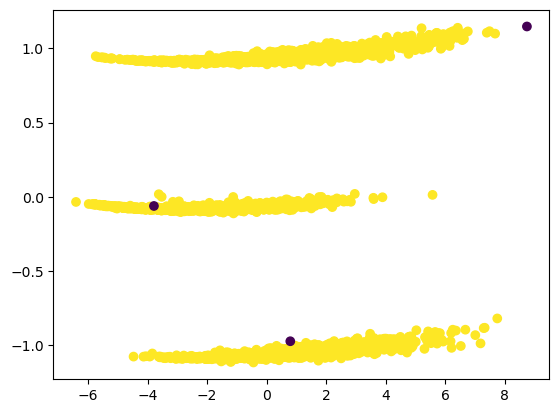

In [46]:
# Performing PCA so that we can plot the results

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 3)
Xt = pca.fit_transform(final_data)

# 2-D plot
plot = plt.scatter(Xt[:,0], Xt[:, 1], c=labels)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


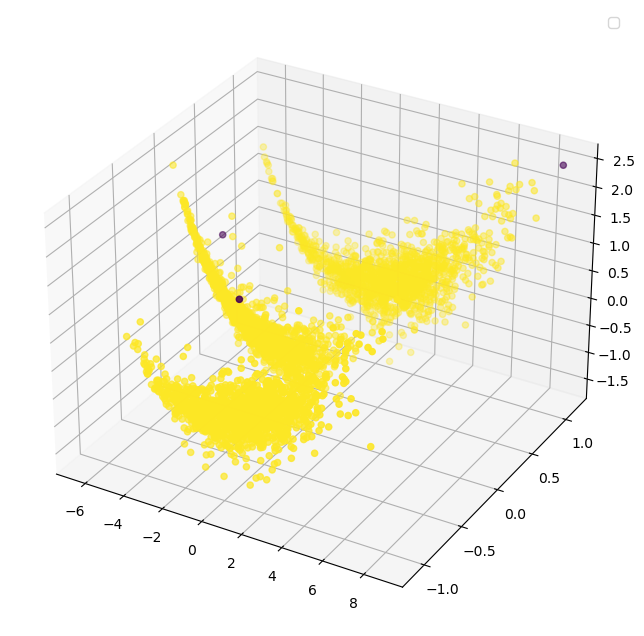

In [47]:
# 3-D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], c=labels)
plt.legend()
plt.show()

### Extra: KMeans++ and HDBSCAN

#### KMeans++ with k = 3

In [48]:
start = time.time()
km = KMeans(n_clusters=3, init="k-means++", random_state=0, n_init="auto", max_iter=300).fit(scaled_X)
end = time.time()
print("KMeans++ took", round(end - start, 2), "seconds to finish.")

KMeans++ took 0.08 seconds to finish.


In [49]:
km.labels_

array([0, 0, 2, ..., 1, 1, 1])

In [50]:
df2['KMeans++'] = km.labels_
df2

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,DBSCAN,KMeans++
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0,2
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,2
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0,2
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,2
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,1
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0,1


#### HDBSCAN

In [51]:
from sklearn.cluster import HDBSCAN
start = time.time()
hdbscan = HDBSCAN(min_samples=4).fit(scaled_X)
end = time.time()
print("HDBSCAN took", round(end - start, 2), "seconds to finish.")

HDBSCAN took 0.24 seconds to finish.


In [52]:
hdbscan.labels_

array([0, 0, 2, ..., 0, 2, 0], dtype=int64)

In [53]:
df2["HDBSCAN"] = hdbscan.labels_
df2

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,DBSCAN,KMeans++,HDBSCAN
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,0
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0,2,2
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,2,0
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0,2,2
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,2,0
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,1,0
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0,1,2
